In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -U -q kaggle

In [6]:
!mkdir -p ~/.kaggle

In [7]:
from google.colab import files

In [8]:
files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"miguelariaslondoo","key":"7418f5016cd15765af60765f150c1ba7"}'}

In [9]:
!cp kaggle.json ~/.kaggle/

In [10]:
!kaggle competitions download -c champs-scalar-coupling

 98% 369M/377M [00:04<00:00, 55.5MB/s]
100% 377M/377M [00:04<00:00, 97.1MB/s]


In [ ]:
!unzip -o '/content/champs-scalar-coupling.zip'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as ps
from sklearn.model_selection import KFold, cross_val_score, learning_curve, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, mean_absolute_error, r2_score
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
import textwrap
from sklearn.decomposition import NMF, PCA
from itertools import product
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

CARGAMOS TODOS LOS DATOS EN SUS RESPECTIVOS DATAFRAMES


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df_dipole_moments = pd.read_csv('dipole_moments.csv')
df_magnetic_shielding_tensors = pd.read_csv('magnetic_shielding_tensors.csv')
df_mulliken_charges = pd.read_csv('mulliken_charges.csv')
df_potential_energy = pd.read_csv('potential_energy.csv')
#df_sample_submission = pd.read_csv('sample_submission.csv')
df_scalar_coupling_contributions = pd.read_csv('scalar_coupling_contributions.csv')
df_structures = pd.read_csv('structures.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')


## Preprosesamiento de datos
Generar el Dataframe completo a utilizar como el generado en el notebook de exploracion de datos

In [3]:
# Data frame of dipole moments and potential energy
# have the same size,are he total number of molecules by name
df_dipole_moments_potential_energy = pd.merge(df_dipole_moments, df_potential_energy, on='molecule_name')
#rename the columns x y z to dipole_moment_x dipole_moment_y dipole_moment_z
df_dipole_moments_potential_energy.rename(columns={'X': 'dipole_moment_x', 'Y': 'dipole_moment_y', 'Z': 'dipole_moment_z'}, inplace=True)
#data frame of magnetic shielding tensors,structures and mulliken charges
#merge the data frames y molecule name and atom index
df_magnetic_shielding_tensors_mulliken_charges_structures = pd.merge(df_magnetic_shielding_tensors, df_mulliken_charges, on=['molecule_name','atom_index'])
df_magnetic_shielding_tensors_mulliken_charges_structures = pd.merge(df_magnetic_shielding_tensors_mulliken_charges_structures, df_structures, on=['molecule_name','atom_index'])
#data frame of train and scalar coupling contributions,have the same size
# merging the 2 data frames by molecule name,type and atom index
df_train_scalar_coupling_contributions = pd.merge(df_train, df_scalar_coupling_contributions, on=['molecule_name','atom_index_0','atom_index_1','type'])
#Now we have to merge df_dipole_moments_potential_energy and df_train_scalar_coupling_contributions
#by molecule name,the is only one molecule name in df_dipole_moments_potential_energy so that means that
#so it must aply to all the rows of df_train_scalar_coupling_contributions by the same name
df_dipole_moments_potential_energy_train_scalar_coupling_contributions = pd.merge(df_dipole_moments_potential_energy, df_train_scalar_coupling_contributions, on=['molecule_name'])
#erase de id column
df_dipole_moments_potential_energy_train_scalar_coupling_contributions.drop(['id'], axis=1, inplace=True)
# putting atom_index_0 and atom_index_1 next to molecule_name
cols = list(df_dipole_moments_potential_energy_train_scalar_coupling_contributions.columns.values)
cols.pop(cols.index('molecule_name'))
cols.pop(cols.index('atom_index_0'))
cols.pop(cols.index('atom_index_1'))
df_dipole_moments_potential_energy_train_scalar_coupling_contributions = df_dipole_moments_potential_energy_train_scalar_coupling_contributions[['molecule_name']+['atom_index_0']+['atom_index_1']+cols]

# first we create df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_0
df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_0 = df_magnetic_shielding_tensors_mulliken_charges_structures.copy()
# rename all the columns of df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_0 adig a AT0 to the end of each column name
# except atom_index and molecule_name
df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_0.rename(columns=lambda x: x + '_AT0' if (x != 'atom_index' and x != 'molecule_name') else x, inplace=True)
df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_0.rename(columns={'atom_index': 'atom_index_0'}, inplace=True)
#we do the same for df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_1
df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_1 = df_magnetic_shielding_tensors_mulliken_charges_structures.copy()
df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_1.rename(columns=lambda x: x + '_AT1' if (x != 'atom_index' and x != 'molecule_name') else x, inplace=True)
df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_1.rename(columns={'atom_index': 'atom_index_1'}, inplace=True)
#the names are very long so we rename the dataframe
df_pm_pe_t_scc = df_dipole_moments_potential_energy_train_scalar_coupling_contributions.copy()
#now we merge the first time df_dipole_moments_potential_energy_train_scalar_coupling_contributions
# with df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_0
df_pm_pe_t_scc_mst_mcs_ai0 = pd.merge(df_pm_pe_t_scc, df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_0, on=['molecule_name','atom_index_0'])
#now we merge the second time df_dipole_moments_potential_energy_train_scalar_coupling_contributions
# with df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_1
df_pm_pe_t_scc_mst_mcs_ai0_ai1 = pd.merge(df_pm_pe_t_scc_mst_mcs_ai0, df_magnetic_shielding_tensors_mulliken_charges_structures_atom_index_1, on=['molecule_name','atom_index_1'])


In [4]:
df_final_train=df_pm_pe_t_scc_mst_mcs_ai0_ai1.copy()

In [5]:
print(df_final_train.head())
print(df_final_train.shape)
df_final_train_test_origin=df_final_train.copy()

      molecule_name  atom_index_0  atom_index_1  dipole_moment_x  \
0  dsgdb9nsd_000001             1             0              0.0   
1  dsgdb9nsd_000001             2             0              0.0   
2  dsgdb9nsd_000001             3             0              0.0   
3  dsgdb9nsd_000001             4             0              0.0   
4  dsgdb9nsd_000001             1             2              0.0   

   dipole_moment_y  dipole_moment_z  potential_energy  type  \
0              0.0              0.0         -40.52368  1JHC   
1              0.0              0.0         -40.52368  1JHC   
2              0.0              0.0         -40.52368  1JHC   
3              0.0              0.0         -40.52368  1JHC   
4              0.0              0.0         -40.52368  2JHH   

   scalar_coupling_constant       fc  ...    YY_AT1  ZY_AT1  XZ_AT1  YZ_AT1  \
0                   84.8076  83.0224  ...  195.3171  0.0007 -0.0001  0.0007   
1                   84.8074  83.0222  ...  195.3171  0

In [11]:
## se toman los primeros 10004 datos,se justifica ya que es el punto donde toda la informacion
# hasta la molecula dsgdb9nsd_000521 esta completa,fallar en tomar toda la informacion de las moleculas generaria un error
# en el modelo,por ende no se toma una aproximacion de toma de muestras aleatoria,
# se considera que para fines academicos no es necesario utilizar mas datos
#tanto por las limitaciones del jupyter y de tiempo

df_final_train_test=df_final_train_test_origin.iloc[:10004,:]
print(df_final_train_test.shape)


(10004, 41)


In [12]:
#Saving the DF origin to a .csv file
df_final_train_test.to_csv('df_final_train_test.csv', index=False)

In [17]:
df_final_train_test = pd.read_csv('df_final_train_test.csv')

In [18]:
df_final_train_test.drop(['molecule_name'],axis=1,inplace=True)


In [19]:
def evaluador_modelos(nombre_modelo, modelo, X_train, y_train, X_test, y_test):
    #se entrena
    y_pred= modelo.predict(X_test)
    #Se obtienen metricas consideradas de importancia
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    r2 = r2_score(y_test, y_pred)
    y_test_mean= y_test.mean()
    mae_ratio= mae/y_test_mean
    rmse_ratio= rmse/y_test_mean
    #Se organiza en una tabla
    tablita = pd.DataFrame(
        data=[[nombre_modelo, mae, mse, rmse, r2, mae_ratio, rmse_ratio]],
        columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"])
    return tablita

In [20]:
print(df_final_train_test.head())


   atom_index_0  atom_index_1  dipole_moment_x  dipole_moment_y  \
0             1             0              0.0              0.0   
1             2             0              0.0              0.0   
2             3             0              0.0              0.0   
3             4             0              0.0              0.0   
4             1             2              0.0              0.0   

   dipole_moment_z  potential_energy  type  scalar_coupling_constant       fc  \
0              0.0         -40.52368  1JHC                   84.8076  83.0224   
1              0.0         -40.52368  1JHC                   84.8074  83.0222   
2              0.0         -40.52368  1JHC                   84.8093  83.0241   
3              0.0         -40.52368  1JHC                   84.8095  83.0243   
4              0.0         -40.52368  2JHH                  -11.2570 -11.0347   

         sd  ...    YY_AT1  ZY_AT1  XZ_AT1  YZ_AT1    ZZ_AT1  \
0  0.254579  ...  195.3171  0.0007 -0.0001  0.

In [21]:
import pandas as pd
import numpy as np

# Select 6 random columns
cols = df_final_train_test.sample(n=6, axis=1).columns

# Replace 5% of the data in those columns with NaN
for col in cols:
    df_final_train_test.loc[df_final_train_test.sample(frac=0.05).index, col] = np.nan


In [22]:
# Calculate the percentage of missing values for each column
missing_percentages = (df_final_train_test.isnull().sum() / len(df_final_train_test) * 100).round(0).astype(str) + '%'
# Printing only the colums that have missing values
print(missing_percentages[missing_percentages != '0.0%'])

scalar_coupling_constant    5.0%
pso                         5.0%
XY_AT0                      5.0%
ZZ_AT1                      5.0%
mulliken_charge_AT1         5.0%
z_AT1                       5.0%
dtype: object


In [23]:
# Crear el objeto LabelEncoder
encoder = ps.LabelEncoder()

# Codificar las columnas no numéricas
df_final_train_test['atom_AT1'] = encoder.fit_transform(df_final_train_test['atom_AT1'])
df_final_train_test['type'] = encoder.fit_transform(df_final_train_test['type'])
df_final_train_test['atom_AT0'] = encoder.fit_transform(df_final_train_test['atom_AT0'])


In [24]:
#replace the missing values with the mean of the column
df_final_train_test.fillna(df_final_train_test.mean(), inplace=True)

In [25]:
x=df_final_train_test.drop(["scalar_coupling_constant"],axis=1)
y=df_final_train_test["scalar_coupling_constant"].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
print (X_train.shape, X_test.shape)

(7002, 39) (3002, 39)


In [27]:
#Creamos el df de resultados
result_df = pd.DataFrame()

**Modelos supervisados:**

RandomForetsRegressor y un DecisionTreeRegresor.


In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Definir los parámetros para el árbol de decisión
parametros_dt = {'max_depth': list(range(1, 20, 5)), 'min_samples_split': [2,3,5], 'min_samples_leaf': [1,2,3]}

# Definir los parámetros para el bosque aleatorio
parametros_rf = {'n_estimators': list(range(1, 100, 20)), 'max_depth': list(range(1, 20, 5)), 'min_samples_split': [2,3,5],
                 'min_samples_leaf': [1,2,3]}

# Crear los modelos
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

# Crear las búsquedas de cuadrícula
grid_dt = RandomizedSearchCV(dt, parametros_dt,scoring = 'neg_mean_squared_error', cv=5,random_state=0)
grid_rf = RandomizedSearchCV(rf, parametros_rf,scoring = 'neg_mean_squared_error',cv=5,random_state=0)

# Ajustar los modelos
grid_dt.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

# Imprimir los mejores parámetros

print("Mejores parámetros para DecisionTreeRegressor: ", grid_dt.best_params_)
print("Mejores parámetros para RandomForestRegressor: ", grid_rf.best_params_)

Mejores parámetros para DecisionTreeRegressor:  {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 6}
Mejores parámetros para RandomForestRegressor:  {'n_estimators': 21, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 6}


In [29]:
Rdm_forest = RandomForestRegressor(n_estimators =grid_rf.best_params_["n_estimators"]
                                   ,max_depth = grid_rf.best_params_["max_depth"],
                                   min_samples_leaf=grid_rf.best_params_["min_samples_leaf"],
                                   min_samples_split=grid_rf.best_params_["min_samples_split"],
                                   random_state=0)
Rdm_forest.fit(X_train, y_train)

DT_Regressor = DecisionTreeRegressor(
                                   max_depth = grid_dt.best_params_["max_depth"],
                                   min_samples_leaf=grid_dt.best_params_["min_samples_leaf"],
                                   min_samples_split=grid_dt.best_params_["min_samples_split"],
                                   random_state=0)
DT_Regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_split=5, random_state=0)

In [30]:
result_rf = evaluador_modelos("RandomForestRegressor", Rdm_forest, X_train, y_train, X_test, y_test)
result_dt = evaluador_modelos("DecisionTreeRegressor", DT_Regressor, X_train, y_train, X_test, y_test)
result_df = result_df.append(result_rf, ignore_index=True)
result_df = result_df.append(result_dt, ignore_index=True)

<ipython-input-30-892aa3f9ae6d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_rf, ignore_index=True)
<ipython-input-30-892aa3f9ae6d>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_dt, ignore_index=True)


**Modelos no supervisados + métodos supervisados:**
Para los modelos no supervisados se optó por  usar algoritmos de kmeans, es decir uso de clusterings y PCA, estos se usaron como complemento para los modelos usados anteriormente;
 kmeans + DecisionTreeRegressor y PCA + RandomForestRegressor


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Definir los parámetros para KMeans + DecisionTreeRegressor
parametros_kmeans_dt = {'kmeans__n_clusters': range(2, 10), 'dt__max_depth': list(range(20, 61, 20)),
                        'dt__min_samples_split': [2, 5, 10], 'dt__min_samples_leaf': [1, 2, 4]}

# Definir los parámetros para PCA + RandomForestRegressor
parametros_pca_rf = {'pca__n_components': range(2, 10), 'rf__n_estimators': [10, 50, 100, 200],
                     'rf__max_depth': list(range(20, 61, 20)), 'rf__min_samples_split': [2, 5, 10],
                     'rf__min_samples_leaf': [1, 2, 4]}

# Crear los pipelines
pipeline_kmeans_dt = Pipeline([
    ("kmeans", KMeans(n_init=10)),
    ("dt", DecisionTreeRegressor())
])

pipeline_pca_rf = Pipeline([
    ("pca", PCA()),
    ("rf", RandomForestRegressor())
])

# Crear las búsquedas aleatorias
random_kmeans_dt = RandomizedSearchCV(pipeline_kmeans_dt, parametros_kmeans_dt,
                                      scoring='neg_mean_squared_error', cv=5, random_state=0)
random_pca_rf = RandomizedSearchCV(pipeline_pca_rf, parametros_pca_rf,
                                   scoring='neg_mean_squared_error', cv=5, random_state=0)

# Ajustar los modelos
random_kmeans_dt.fit(X_train, y_train)
random_pca_rf.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejores parámetros para KMeans + DecisionTreeRegressor: ", random_kmeans_dt.best_params_)
print("Mejores parámetros para PCA + RandomForestRegressor: ", random_pca_rf.best_params_)

Mejores parámetros para KMeans + DecisionTreeRegressor:  {'kmeans__n_clusters': 4, 'dt__min_samples_split': 10, 'dt__min_samples_leaf': 4, 'dt__max_depth': 40}
Mejores parámetros para PCA + RandomForestRegressor:  {'rf__n_estimators': 10, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 20, 'pca__n_components': 8}


In [32]:
# Obtener los mejores parámetros
mejores_parametros_kmeans_dt = random_kmeans_dt.best_params_
mejores_parametros_pca_rf = random_pca_rf.best_params_

# Crear nuevos modelos con los mejores parámetros
mejor_kmeans = KMeans(n_clusters=mejores_parametros_kmeans_dt['kmeans__n_clusters'])
mejor_dt = DecisionTreeRegressor(max_depth=mejores_parametros_kmeans_dt['dt__max_depth'],
                                 min_samples_split=mejores_parametros_kmeans_dt['dt__min_samples_split'],
                                 min_samples_leaf=mejores_parametros_kmeans_dt['dt__min_samples_leaf'])

mejor_pca = PCA(n_components=mejores_parametros_pca_rf['pca__n_components'])
mejor_rf = RandomForestRegressor(n_estimators=mejores_parametros_pca_rf['rf__n_estimators'],
                                 max_depth=mejores_parametros_pca_rf['rf__max_depth'],
                                 min_samples_split=mejores_parametros_pca_rf['rf__min_samples_split'],
                                 min_samples_leaf=mejores_parametros_pca_rf['rf__min_samples_leaf'])

# Ajustar los modelos
X_train_kmeans = mejor_kmeans.fit_transform(X_train)
mejor_dt.fit(X_train_kmeans, y_train)

X_train_pca = mejor_pca.fit_transform(X_train)
mejor_rf.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=10)

In [33]:


# Evaluar el modelo DecisionTreeRegressor + Kmeans
resultados_dt_km = evaluador_modelos("DecisionTreeRegressor + Kmeans", mejor_dt, X_train_kmeans, y_train, mejor_kmeans.transform(X_test), y_test)

# Evaluar el modelo RandomForestRegressor + PCA
resultados_rf_pca = evaluador_modelos("RandomForestRegressor + PCA", mejor_rf, X_train_pca, y_train, mejor_pca.transform(X_test), y_test)

# Agregar los resultados al DataFrame existente
result_df = result_df.append(resultados_rf_pca, ignore_index=True)
result_df = result_df.append(resultados_dt_km, ignore_index=True)

<ipython-input-33-d392f94b6aa4>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(resultados_rf_pca, ignore_index=True)
<ipython-input-33-d392f94b6aa4>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(resultados_dt_km, ignore_index=True)


**Resultados:** 

In [34]:
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RandomForestRegressor,2.214607,56.273937,7.501596,0.957326,0.122195,0.413915
1,DecisionTreeRegressor,2.470615,64.156605,8.009782,0.951348,0.136321,0.441955
2,RandomForestRegressor + PCA,6.868078,169.727112,13.027936,0.871292,0.378959,0.718841
3,DecisionTreeRegressor + Kmeans,6.322123,158.750003,12.599603,0.879616,0.348835,0.695207


**Curvas de aprendizaje:**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=5, n_jobs=10, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots()

    axes.set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")

    return plt





<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

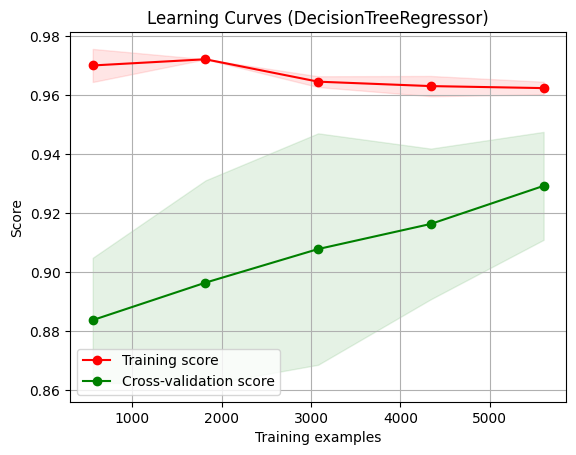

In [36]:
X, y = X_train, y_train
title = "Learning Curves (DecisionTreeRegressor)"
plot_learning_curve(DT_Regressor, title, X, y, cv=5)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

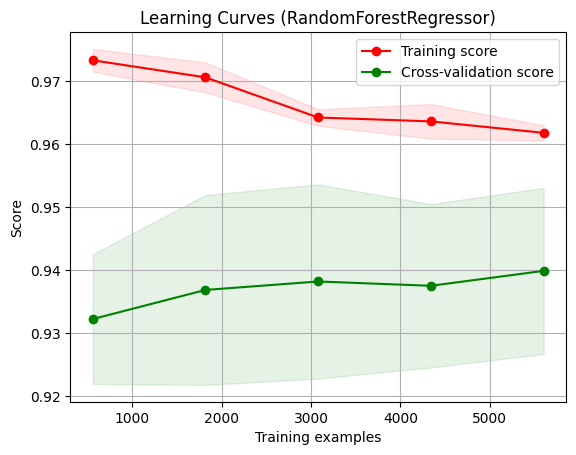

In [37]:

title = "Learning Curves (RandomForestRegressor)"
plot_learning_curve(Rdm_forest, title, X, y, cv=5)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

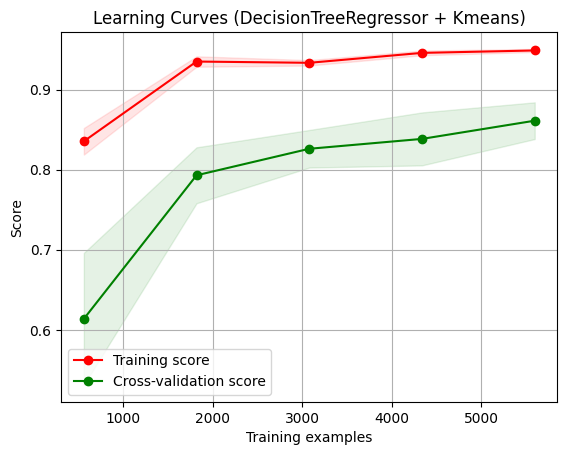

In [38]:
X, y = X_train_kmeans, y_train
title = "Learning Curves (DecisionTreeRegressor + Kmeans)"
plot_learning_curve(mejor_dt, title, X, y, cv=5)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

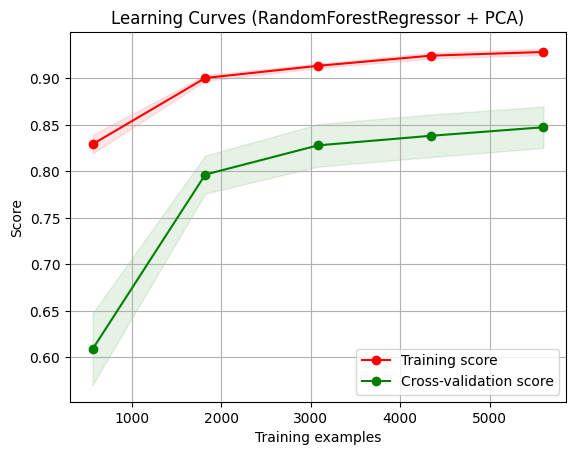

In [39]:
X, y = X_train_pca, y_train
title = "Learning Curves (RandomForestRegressor + PCA)"
plot_learning_curve(mejor_rf, title, X, y, cv=5)